# Estimating Covariance and Expected Returns

We've backtested CW and EW Portfolios and they each have unique positions in industrial implementations.

CapWeighted portfolios are the overall average and hence the de-facto industry standard. They are very inexpensive to implement and feature very low turnover. In many ways, they are the default go-to implementation choice for many investors.

However, we've seen that they suffer from some disadvantages, so there is some room for improvement.

EW are the most obvious improvement because they are the only other technique we are going to look at (other than CW) that requires no estimation of either covariance or expected returns. We've already backtested those and we've seen how easy they are to build.

We'll now move on the more sophisticated portfolio construction techniques, but they will get us involved in the estimation game, something we've avoided so far ... so let's start by pulling in the data we need and start with the CW and EW portfolios, since they are the baseline portfolios.

In [2]:
import numpy as np
import pandas as pd

import edhec_risk_kit_205 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="ew", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.59806
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.58785


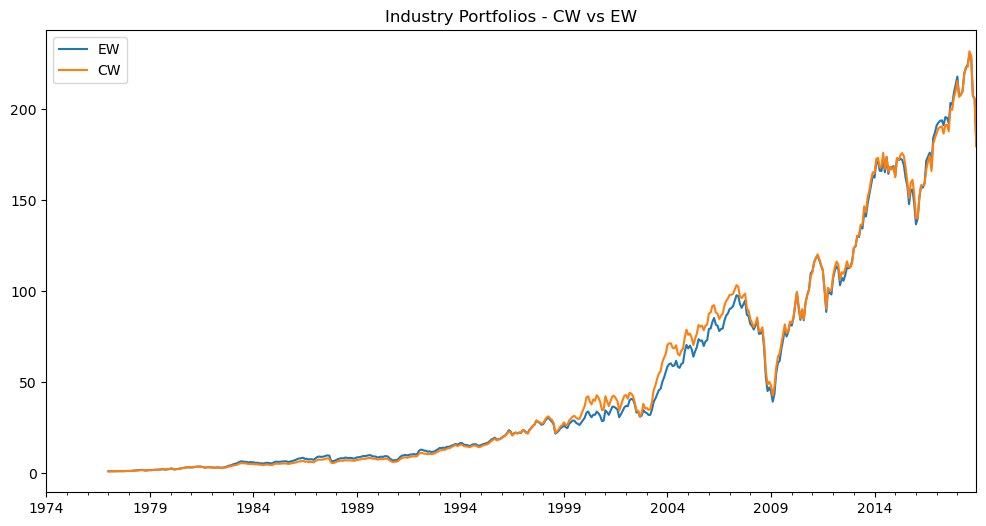

In [2]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

# Building the Global Minimum Variance Portfolio

We've previously written the code (in MOOC 1) to build the GMV portfolio, given the covariance. Let's start with just that:


In [3]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)


Now, let's run this new backtest. This may take a fair amount of time to run, so be patient - we are running a backtest over nearly 50 years and both optimizing and rebalancing on a monthly basis ... this will take a while!

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153092,0.116303,-0.811391,6.408577,0.047674,0.072557,1.030052,-0.463916


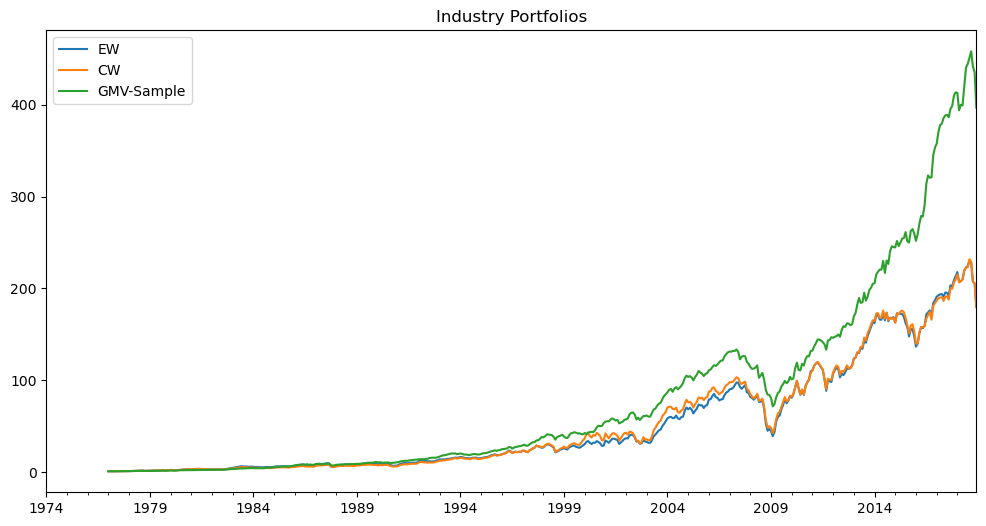

In [4]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


In [5]:
#import statsmodels.stats.moment_helpers as mh
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

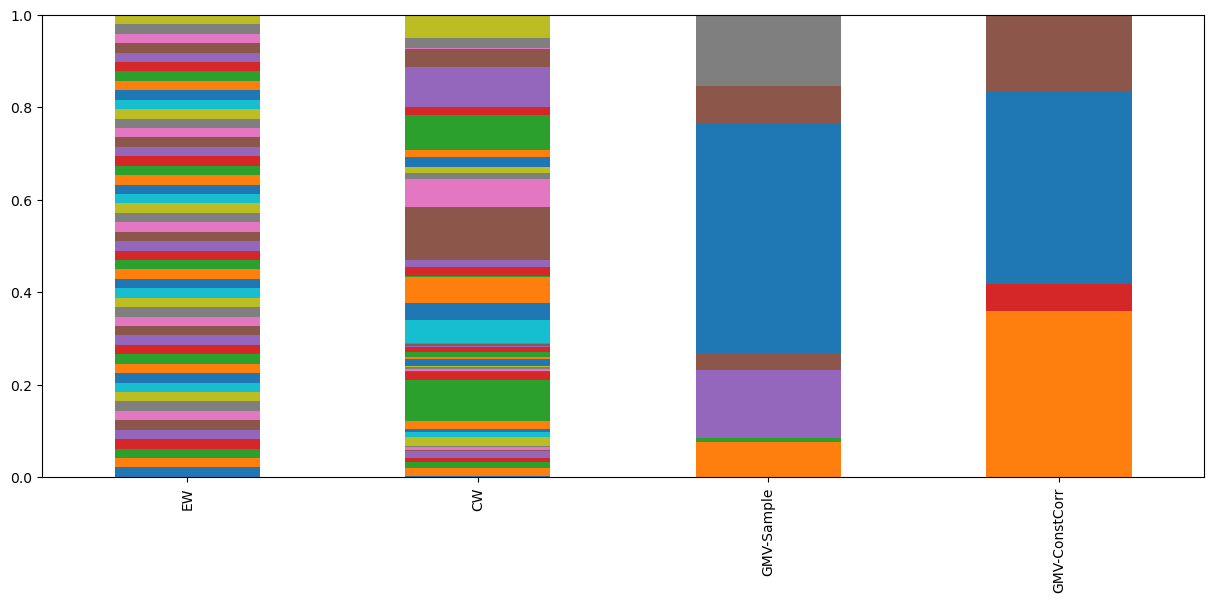

In [6]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2016":]),
    "CW": erk.weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);


In [5]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

NameError: name 'cc_cov' is not defined

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practiotioners choose $0.5$. Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

In [8]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample


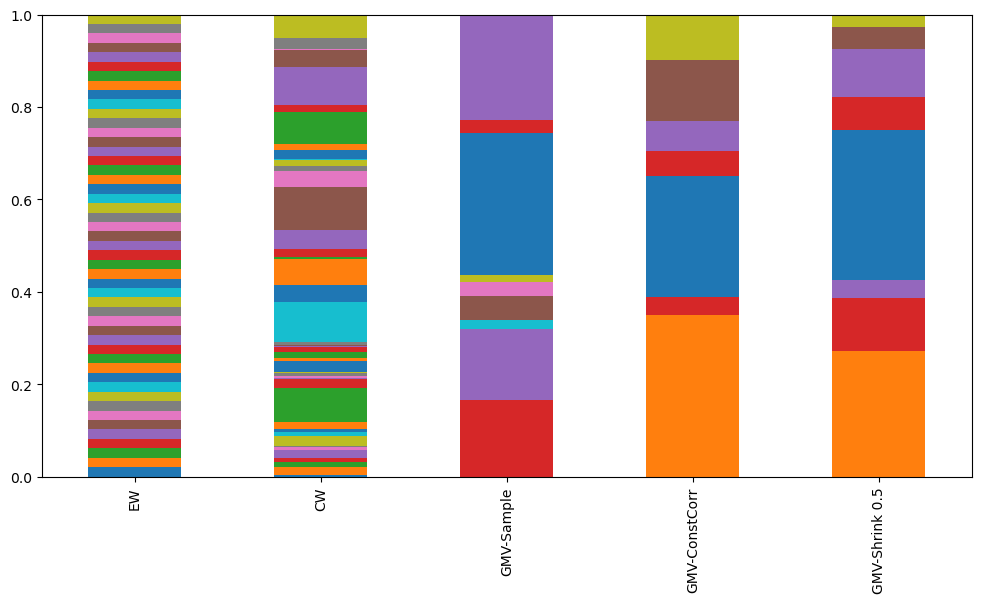

In [9]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2013":]),
    "CW": erk.weight_cw(ind_rets["2013":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153092,0.116303,-0.811404,6.408592,0.047674,0.072557,1.030057,-0.463914
GMV-CC,0.132377,0.115347,-0.890937,6.072480,0.049608,0.075266,0.863769,-0.524088
GMV-Shrink 0.5,0.138503,0.114872,-0.886404,6.306088,0.048715,0.074239,0.919254,-0.518467


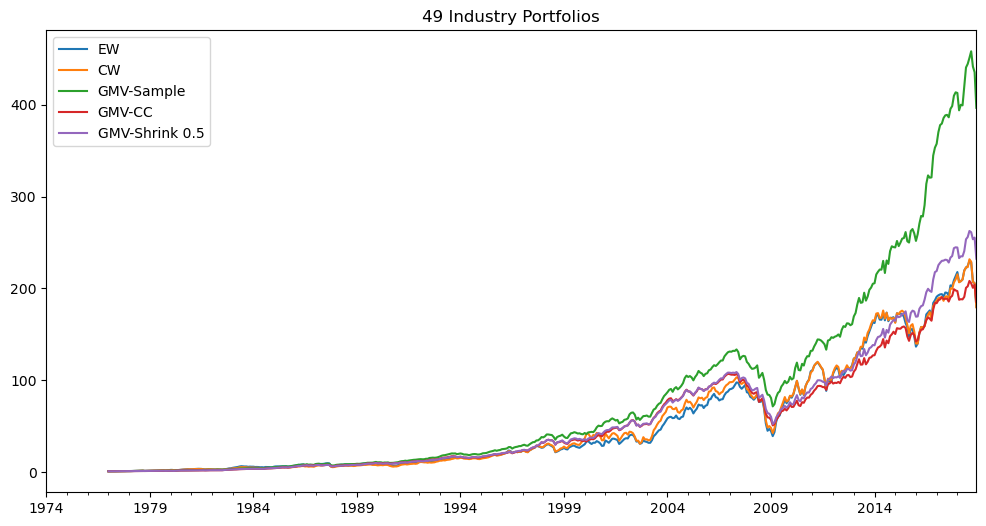

In [10]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153092,0.116303,-0.811404,6.408592,0.047674,0.072557,1.030057,-0.463914
GMV-CC,0.132377,0.115347,-0.890937,6.072480,0.049608,0.075266,0.863769,-0.524088
GMV-Shrink 0.8,0.134113,0.114646,-0.897734,6.152380,0.049121,0.074813,0.883793,-0.523134


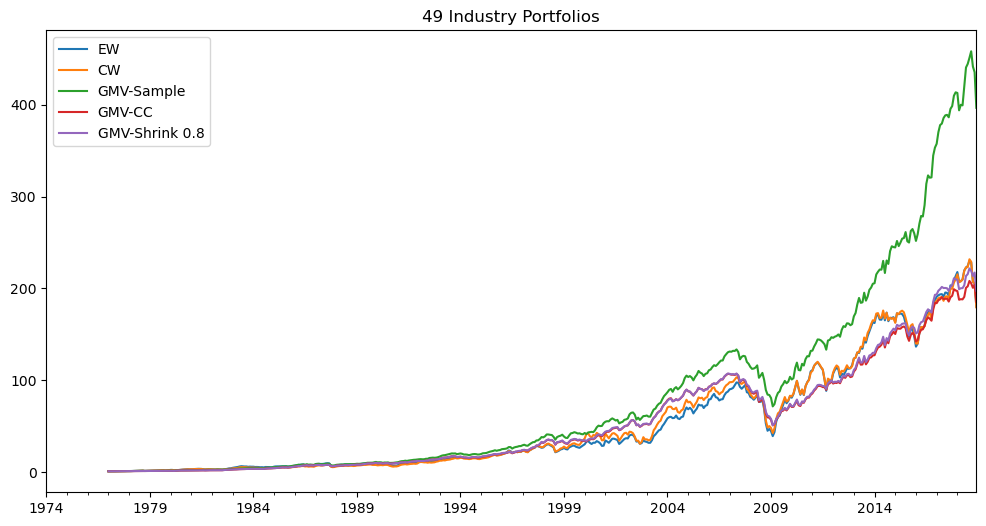

In [12]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.8)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.8': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())

In [29]:
r = ind_rets
n_periods = r.shape[0]
estimation_window = 36
windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
win = windows[1]
win
#weights = [weighting(r.iloc[win[0]:win[1]]) for win in windows]
#weights = [erk.weight_cw(r.iloc[win[0]:win[1]],ind_mcap)]
#weights
#w = ind_mcap.loc[ind_rets.index[1]]
#w
r.iloc[win[0]:win[1]]

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-02,0.0720,0.0465,-0.0051,-0.0095,0.0175,0.0180,0.0138,-0.0097,0.0250,0.0127,...,0.0133,0.0625,0.0099,0.0046,-0.0084,0.0086,-0.0092,-0.0343,0.0129,0.0129
1974-03,-0.0084,0.0063,0.0143,-0.0053,-0.0700,0.0079,0.0113,0.0415,0.0179,0.0063,...,0.0682,0.0197,0.0260,0.0217,0.0705,-0.0003,-0.0112,-0.0040,-0.0004,0.0045
1974-04,-0.0735,-0.0421,-0.0660,-0.0597,-0.0258,-0.0480,-0.0446,-0.0361,-0.0667,-0.0470,...,-0.0057,-0.0511,-0.0426,-0.0516,-0.0672,-0.0470,-0.0605,-0.0899,-0.0663,-0.0494
1974-05,-0.0697,-0.0595,-0.0745,-0.0507,-0.0328,-0.0694,-0.0724,-0.0382,-0.0454,-0.0744,...,-0.0456,-0.0675,-0.0802,-0.0603,-0.0484,-0.1026,-0.0766,-0.1091,-0.0865,-0.0671
1974-06,-0.0663,-0.0183,-0.0090,-0.0415,0.0129,-0.0403,0.0332,0.0044,-0.0409,-0.0186,...,-0.0095,-0.0056,-0.0368,-0.0353,-0.0228,-0.0614,-0.0446,-0.0799,-0.0517,-0.0387
1974-07,-0.0303,-0.0493,-0.0992,-0.0909,-0.0252,-0.1051,-0.0613,-0.0362,-0.0748,-0.0547,...,-0.0199,-0.0429,-0.0431,-0.0512,-0.0693,-0.0444,-0.0622,-0.0993,-0.0673,-0.0570
1974-08,-0.0960,-0.0691,-0.0928,-0.1086,-0.0556,-0.0792,-0.0653,-0.0791,-0.0913,-0.0543,...,-0.0733,-0.0791,-0.0881,-0.0931,-0.0574,-0.1011,-0.0801,-0.1361,-0.0974,-0.0857
1974-09,-0.1137,-0.0639,-0.1095,-0.0838,-0.0776,-0.0875,-0.0619,-0.0664,-0.1001,-0.0754,...,-0.0600,-0.0750,-0.1055,-0.0798,-0.1150,-0.0514,-0.0492,-0.0601,-0.0490,-0.0788
1974-10,0.2843,0.1141,0.0724,0.0684,0.1332,0.0223,0.0044,0.0500,0.1008,0.0158,...,0.0733,0.1298,0.1016,0.0605,0.0665,0.1221,0.1010,-0.0135,0.0709,0.0914
1974-11,-0.0076,-0.0116,-0.0632,-0.0611,-0.0059,-0.0792,-0.0228,-0.0396,-0.0590,-0.0904,...,-0.0641,-0.0786,-0.0454,-0.0634,-0.0843,-0.0345,-0.0204,-0.1161,-0.0429,-0.0505
